## There is no ML here

***

In [443]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [148]:
# ~3.5s
# Reading data for version 1

de_train = pd.read_parquet("C:\Личные документы\data\single_cell\de_train.parquet")
id_map = pd.read_csv("C:\Личные документы\data\single_cell\id_map.csv")
sample_submission = pd.read_csv("C:\Личные документы\data\single_cell\sample_submission.csv")

![version 1](version_1.png)

***

## Version 1.0

Наивный прогноз - просто заполняем средним значение DE для каждого гена полученом для клеток всех типов при воздействии определённого лекарства

In [ ]:
# version 1.0
# public score = 0.627

gene_names = de_train.columns[5:]
sm_name = de_train.groupby('sm_name')[gene_names].mean().reset_index()
sample = id_map.merge(sm_name, on='sm_name', how='left')
sample = sample.drop(['cell_type', 'sm_name'], axis=1)
sample.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

## Version 2.0

Попробуем определить DE каждого гена в зависимости от типа оклетки и лекарства по формуле:

$DE_i = w^i_0 + w^i_1 x_1 + w^i_2 x_2$

$i$ - каждый ген

$DE_i$ - таргет (отклик гена на лечение)

$x_1$ - признак типа клетки 

$x_2$ - признак лекарственного средства
        
$w^i_0$ - свободный член регрессии

$w^i_1 \ и \ w^i_2$ - веса признаков

Идея построить 18211 линейных регрессий (на каждый ген - своя)


In [321]:
df = de_train.copy()
df.head(2)
sm_dict = dict(zip(df['sm_name'].unique(), np.linspace(1, 10, len(df['sm_name'].unique()))))
cell_dict = dict(zip(df['cell_type'].unique(), np.linspace(1, 10, len(df['cell_type'].unique()))))

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887


In [439]:
# ~27s
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.iloc[:,[0, 1]].values
w_list = []
mse_list = []

for i in np.arange(2, df.shape[1]):
    model = LinearRegression().fit(X, df.iloc[:, i])
    y_pred = model.predict(X)
    w_list.append(model.coef_)
    mse_list.append(mean_squared_error(df.iloc[:, i], y_pred))

w_list = np.array(w_list)

***

## Какие клатки похожи на какие?

In [685]:
df = de_train.copy()
df.head(2)
sm_dict = dict(zip(df['sm_name'].unique(), np.linspace(1, 10, len(df['sm_name'].unique()))))
cell_dict = dict(zip(df['cell_type'].unique(), np.linspace(1, 10, len(df['cell_type'].unique()))))

In [686]:
df['cell_type'].unique()

array(['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells',
       'B cells', 'Myeloid cells'], dtype=object)

In [687]:
df[df['sm_name'] == 'Proscillaridin A;Proscillaridin-A']

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
110,NK cells,Proscillaridin A;Proscillaridin-A,LSM-1476;LSM-5290,C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...,False,-0.414059,-0.087885,-5.868917,-14.893129,-0.762398,...,6.491990,-0.607590,-1.439823,-0.569582,1.160231,0.363346,-0.216297,-0.506853,-4.019128,0.452598
111,T cells CD4+,Proscillaridin A;Proscillaridin-A,LSM-1476;LSM-5290,C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...,False,-0.767250,-0.163089,-0.646206,-3.473009,0.241124,...,0.513831,0.581219,-0.434437,0.173986,1.400341,1.571638,-0.242477,-2.021973,-4.161092,0.953246
112,T cells CD8+,Proscillaridin A;Proscillaridin-A,LSM-1476;LSM-5290,C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...,False,2.550141,2.811616,2.112481,2.704562,5.075021,...,1.403159,3.447395,2.074856,5.720255,4.447093,3.827585,1.779095,1.016348,-0.362373,0.247632
113,T regulatory cells,Proscillaridin A;Proscillaridin-A,LSM-1476;LSM-5290,C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...,False,5.284536,2.998061,6.298752,7.443066,8.296250,...,0.899732,2.474840,2.274385,3.374389,5.505521,4.190637,1.949707,0.741826,-0.805133,1.459207


In [688]:
df['sm_name'] = df['sm_name'].apply(lambda x: x.replace('Proscillaridin A;Proscillaridin-A', 'Proscillaridin-A'))
df['sm_lincs_id'] = df['sm_lincs_id'].apply(lambda x: x.replace('LSM-1476;', ''))
df['sm_lincs_id'] = df['sm_lincs_id'].apply(lambda x: x.replace('LSM-', ''))
df['sm_lincs_id'] = df['sm_lincs_id'].apply(lambda x: x[:-3])

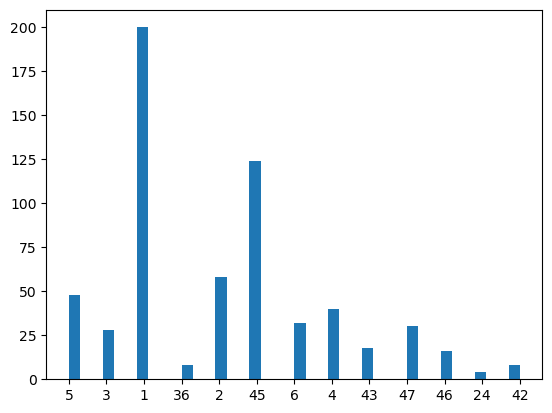

In [704]:
plt.hist(df['sm_lincs_id'], bins=40,);

In [705]:
nk_df = df[df['cell_type'] == 'NK cells']
t_cd4_df = df[df['cell_type'] == 'T cells CD4+']
t_cd8_df = df[df['cell_type'] == 'T cells CD8+']
t_r_df = df[df['cell_type'] == 'T regulatory cells']
b_df = df[df['cell_type'] == 'B cells']
m_df = df[df['cell_type'] == 'Myeloid cells']

print(f"Shape of NK cells data: {nk_df.shape}")
print(f"Shape of T cells CD4+ data: {t_cd4_df.shape}")
print(f"Shape of T cells CD8+ data: {t_cd8_df.shape}")
print(f"Shape of T regulatory cells data: {t_r_df.shape}")
print(f"Shape of B cells data: {b_df.shape}")
print(f"Shape of Myeloid cells data: {m_df.shape}")

Shape of NK cells data: (146, 18216)
Shape of T cells CD4+ data: (146, 18216)
Shape of T cells CD8+ data: (142, 18216)
Shape of T regulatory cells data: (146, 18216)
Shape of B cells data: (17, 18216)
Shape of Myeloid cells data: (17, 18216)


In [708]:
nk_df['sm_lincs_id'].unique()

array(['5', '3', '1', '36', '2', '45', '6', '4', '43', '47', '46', '24',
       '42'], dtype=object)

In [712]:
df[df['sm_lincs_id'] == '3']['A1BG']

4      4.290652
5      0.618061
6     -0.148131
7      0.561473
60    -1.039965
61     0.293437
62    -0.738414
63    -0.307503
64    -0.343319
65    -0.352723
66    -1.426983
67     2.423859
68    -0.481542
69     1.085040
70     0.236063
71     1.080779
137    1.074751
138   -0.393812
139    0.706924
140    0.312872
459   -0.449937
460   -0.031262
461    0.407090
462    0.253093
505    0.045184
506   -0.597152
507   -0.636060
508    0.628341
Name: A1BG, dtype: float64

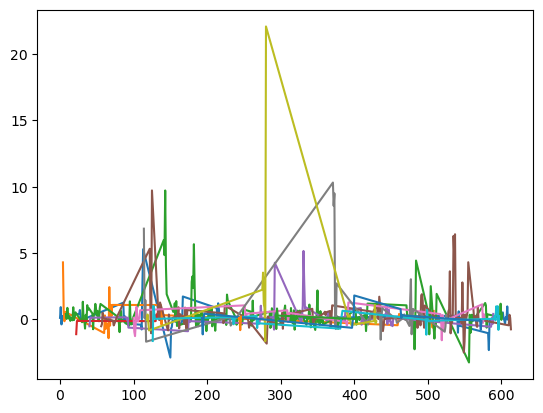

In [713]:
for i in nk_df['sm_lincs_id'].unique():
    plt.plot(df[df['sm_lincs_id'] == i]['A1BG'])

In [706]:
nk_df.iloc[:,5:].values

array([[ 0.10472047, -0.07752421, -1.62559604, ...,  0.03412678,
         0.22137655,  0.36875538],
       [ 4.2906521 , -0.06386359, -0.01744324, ...,  0.11236464,
        -0.12219311,  0.67662888],
       [ 0.86148677, -0.11231322, -0.35521712, ..., -0.14169934,
        -0.75651001, -0.07693369],
       ...,
       [ 0.51784905,  0.93518045, -0.6873407 , ...,  0.0062    ,
         0.15266354,  1.06804517],
       [ 0.16175982, -0.1118389 ,  0.4352723 , ...,  0.69789718,
        -0.12016755, -0.82747285],
       [-0.45554949,  0.18818145,  0.59573378, ..., -0.23164198,
         1.02399363, -0.06476045]])

In [363]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'MAE_train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MAE_test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE_train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE_test: {mean_squared_error(y_test, y_test_pred)}')

MAE_train: 0.8577787209627721
MAE_test: 0.7299198623613803
MSE_train: 3.027957400651752
MSE_test: 0.9751729303182122


In [349]:
model.coef_

array([[ 0.1189257 , -0.02123414]])

In [356]:
model_1 = LinearRegression().fit(X.values, y.values)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'MAE_train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MAE_test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE_train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE_test: {mean_squared_error(y_test, y_test_pred)}')
model_1.coef_

MAE_train: 0.7977768996701963
MAE_test: 1.5887836973548817
MSE_train: 2.6102448614842513
MSE_test: 2.5242336369806484


array([[ 0.09936948, -0.022432  ]])

In [191]:
from sklearn.model_selection import train_test_split

df_sm = df.drop(['cell_type', 'sm_lincs_id', 'SMILES', 'control', 'sm_name'], axis=1)

new_y = np.zeros_like(y)
sm_dict = dict(zip(set(y), range(len(set(y)))))

for i in range(len(y)):
    new_y[i] = sm_dict[y[i]]
    
X = df.drop(['cell_type', 'sm_lincs_id', 'SMILES', 'control', 'sm_name'], axis=1)
y = df['sm_name']

X_train, X_valid, y_train, y_valid = train_test_split(X.values, new_y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score

# Подготовом сеты данных
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_valid, y_valid)

# потренируем модель
booster = lgb.train({"objective": "multiclass", "num_class":len(y.unique()), "verbosity": -1},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=200)

# Сделаем предсказания
train_preds = booster.predict(X_train)
valid_preds = booster.predict(X_valid)
set_preds = booster.predict(X)

train_preds = np.argmax(train_preds, axis=1)
valid_preds = np.argmax(valid_preds, axis=1)
set_preds = np.argmax(set_preds, axis=1)

np.argmax(booster.predict(X.iloc[4]), 1)
res = dict((v,k) for k,v in sm_dict.items())
res[65]

In [239]:
adata_obs_meta

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240085,ffff28f274e983df,library_27,plate_0,G12,G,12,PBMC,donor_0,NK cells,LSM-3349,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,1.0,24,False
240086,ffff32893af5befb,library_31,plate_4,E7,E,7,PBMC,donor_2,T cells CD4+,LSM-2287,Midostaurin,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,1.0,24,False
240087,ffff6c3e0a7b05ad,library_38,plate_1,C5,C,5,PBMC,donor_2,NK cells,LSM-45786,BAY 87-2243,Cc1cc(-c2nc(-c3ccc(OC(F)(F)F)cc3)no2)nn1Cc1ccn...,1.0,24,False
240088,ffff8e571c7e8cb0,library_28,plate_5,B1,B,1,PBMC,donor_1,B cells,LSM-43181,Belinostat,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,0.1,24,True


In [ ]:
gene_names = de_train.columns[5:]
gene_group = de_train.groupby('cell_type')[gene_names].mean().reset_index()

b_cells_coef = gene_group.iloc[0] / gene_group.sum()
myeloid_cells_coef = gene_group.iloc[1] / gene_group.sum()

b_train = de_train.groupby('sm_name')[gene_names].mean().reset_index() * b_cells_coef
myeloid_train = de_train.groupby('sm_name')[gene_names].mean().reset_index() * myeloid_cells_coef

b_cell_sample = id_map[id_map['cell_type'] == 'B cells']
myeloid_cell_sample = id_map[id_map['cell_type'] == 'Myeloid cells']

sample = pd.concat([
    b_cell_sample.merge(b_train, on='sm_name', how='left'), 
    myeloid_cell_sample.merge(myeloid_train, on='sm_name', how='left')], axis=0)

sample = sample.drop(['cell_type', 'sm_name'], axis=1)

In [111]:
sample.to_csv('submission.csv', index=False)

In [115]:
pd.read_csv('submission.csv')

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.099893,-0.027272,-0.774249,0.821812,0.275410,0.243175,0.008552,0.049844,-0.749450,...,-0.682501,-0.396681,-0.074171,0.166738,0.114959,0.182695,0.266521,0.295874,-0.040651,-0.148988
1,1,-0.027042,0.001774,-0.152250,-0.070382,0.082435,0.086938,-0.010954,0.005648,0.271373,...,0.382043,0.054525,0.021656,-0.089872,0.044785,-0.014379,0.067912,-0.124355,0.012591,0.025167
2,2,0.135738,0.078246,-0.201363,-0.027517,0.158613,0.387594,0.051293,0.044774,-0.103556,...,0.165436,-0.103508,-0.006885,0.264491,0.034569,0.071429,0.153815,-0.047643,-0.025140,0.196532
3,3,-0.010357,0.129446,-0.233765,0.135129,-0.006669,0.013345,-0.011868,0.190723,-0.016749,...,-0.089430,0.037551,-0.047152,0.198801,0.003894,0.031490,0.000223,0.139910,-0.014389,-0.044904
4,4,0.080754,-0.066910,-0.296683,0.149611,-0.001257,0.061783,-0.015574,0.038356,-0.205885,...,-0.624950,-0.051051,0.029448,-0.215859,0.010607,0.101737,-0.094264,0.426026,0.004142,-0.021385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.002299,-0.231458,-0.919729,-0.153612,0.055543,-0.198833,0.032114,0.027152,-0.030219,...,-0.105657,0.005003,-0.552201,0.007293,-0.083175,-0.072014,-0.058017,0.002708,0.035367,0.058643
251,251,0.071125,-0.158138,0.428921,0.137932,0.146518,0.090070,-0.201706,-0.045119,-0.034588,...,-0.021602,0.010111,0.218076,-0.012292,0.090167,-0.022015,0.104993,-0.202731,-0.064556,-0.051102
252,252,-0.036818,0.181243,-1.354369,-0.048798,0.010956,-0.101196,-0.228552,-0.078443,0.011120,...,-0.040979,-0.004443,0.777329,-0.012043,0.032585,-0.021074,0.085073,-0.108479,0.085032,-0.088946
253,253,0.028453,0.005014,1.812997,-0.002953,0.173880,-0.085194,0.545533,0.148111,0.404640,...,-0.298476,-0.047705,-0.591147,0.007709,-0.239931,0.087912,0.058833,-0.120128,-0.007765,0.062439


In [133]:
id_map

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


In [145]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [136]:
sm_name = de_train.groupby('sm_name')[gene_names].mean().reset_index()

In [147]:

sm_name = de_train.groupby('sm_name')[gene_names].mean().reset_index()
sample = id_map.merge(sm_name, on='sm_name', how='left')
sample = sample.drop(['cell_type', 'sm_name'], axis=1)
sample.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,1,-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,2,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,3,-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,4,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,251,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,252,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,253,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


In [139]:
sample

,id,cell_type,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,1,B cells,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,2,B cells,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,3,B cells,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,4,B cells,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,Myeloid cells,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,251,Myeloid cells,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,252,Myeloid cells,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,253,Myeloid cells,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


In [142]:
sample[sample['sm_name'] == 'Vanoxerine']

,id,cell_type,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
124,124,B cells,Vanoxerine,0.188002,-0.459637,0.107419,0.44263,0.288657,0.239626,-0.191168,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
251,251,Myeloid cells,Vanoxerine,0.188002,-0.459637,0.107419,0.44263,0.288657,0.239626,-0.191168,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
